In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('houses_train.csv')
df.head()

,Unnamed: 0,price,condition,district,max_floor,street,num_rooms,region,area,url,num_bathrooms,building_type,floor,ceiling_height
0,5546,130000.0,newly repaired,Center,4,Sayat Nova Ave,3,Yerevan,96.0,http://www.myrealty.am/en/item/28244/3-senyaka...,1,stone,3,3.2
1,2979,65000.0,good,Arabkir,5,Hr.Kochar St,3,Yerevan,78.0,http://www.myrealty.am/en/item/18029/3-senyaka...,1,stone,2,2.8
2,2698,129000.0,good,Center,10,M.Khorenatsi St,3,Yerevan,90.0,http://www.myrealty.am/en/item/37797/3-senyaka...,1,panel,3,2.8
3,4548,52000.0,newly repaired,Center,14,Argishti St,2,Yerevan,53.0,http://www.myrealty.am/en/item/36153/2-senyaka...,1,monolit,5,3.0
4,2982,65000.0,newly repaired,Center,12,Mashtots Ave,2,Yerevan,47.0,http://www.myrealty.am/en/item/17566/2-senyaka...,1,panel,3,2.8


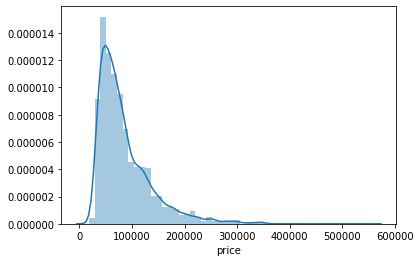

In [3]:
#let's look at the distribution of our target feature 'price'
sns.distplot(df['price'])

As we can see our target feature has a right skewed distribution and has outlier(s) above 400,000$

In [4]:
df.sort_values('price',ascending=False).head(2)

,Unnamed: 0,price,condition,district,max_floor,street,num_rooms,region,area,url,num_bathrooms,building_type,floor,ceiling_height
1189,100,550000.0,newly repaired,Center,8,Northern Ave,3,Yerevan,140.0,http://www.myrealty.am/en/item/30495/3-senyaka...,2,other,6,3.0
1683,1328,400000.0,newly repaired,Center,9,Northern Ave,3,Yerevan,127.0,http://www.myrealty.am/en/item/27507/3-senyaka...,2,monolit,4,3.0


In [5]:
df.drop(1189,axis=0,inplace=True) #removing outlier

In [8]:
df.nunique()

Unnamed: 0        4999
price              332
condition            3
district            13
max_floor           23
street             336
num_rooms            6
region               1
area               122
url               4999
num_bathrooms        4
building_type        4
floor               20
ceiling_height       5
dtype: int64

We can see that features: 'Unnamed:0', 'url', 'region' can be dropped from our dataframe since they don't provide any useful information for analysis.
Moreover we can see that features 'district' and 'street' provide similar information. Let's check and see if we should remove the feature 'street' or not.

In [9]:
print(df.sort_values('price',ascending=False)[['street','district','price']].head(50))

print(df.sort_values('price',ascending=False)[['street','district','price']].tail(50))

                street district     price
1683      Northern Ave   Center  400000.0
4477     Vardanants St   Center  351000.0
122       Northern Ave   Center  350000.0
2312        Abovyan St   Center  350000.0
3752           Aram St   Center  350000.0
1874      Northern Ave   Center  350000.0
2308         Buzand St   Center  344000.0
3023      Northern Ave   Center  340000.0
3729      Northern Ave   Center  340000.0
4090      Northern Ave   Center  340000.0
4661      Northern Ave   Center  340000.0
1508      Northern Ave   Center  340000.0
3671      Northern Ave   Center  340000.0
3277      Northern Ave   Center  340000.0
1667           Aram St   Center  330000.0
4390      Moskovyan St   Center  330000.0
4106      Northern Ave   Center  325000.0
1282      Northern Ave   Center  320000.0
568      Arabkir 27 St  Arabkir  320000.0
391            Aram St   Center  320000.0
686       Northern Ave   Center  320000.0
2550       Tamanyan St   Center  315000.0
1119           Aram St   Center  3

As we see the highest prices are in Center and Arabkir districts, while the lowest prices are in city suburb. The exact name of the street is not so important so we will drop that feature as well.

In [6]:
df.drop(['region','Unnamed: 0','url','street'],inplace=True,axis=1) #removing extra useless information

Now let's separate numerical and categorical features for a brief EDA analysis.

In [7]:
df_num = df.select_dtypes(include=['float64','int64'])
df_obj = df.select_dtypes(include='O')

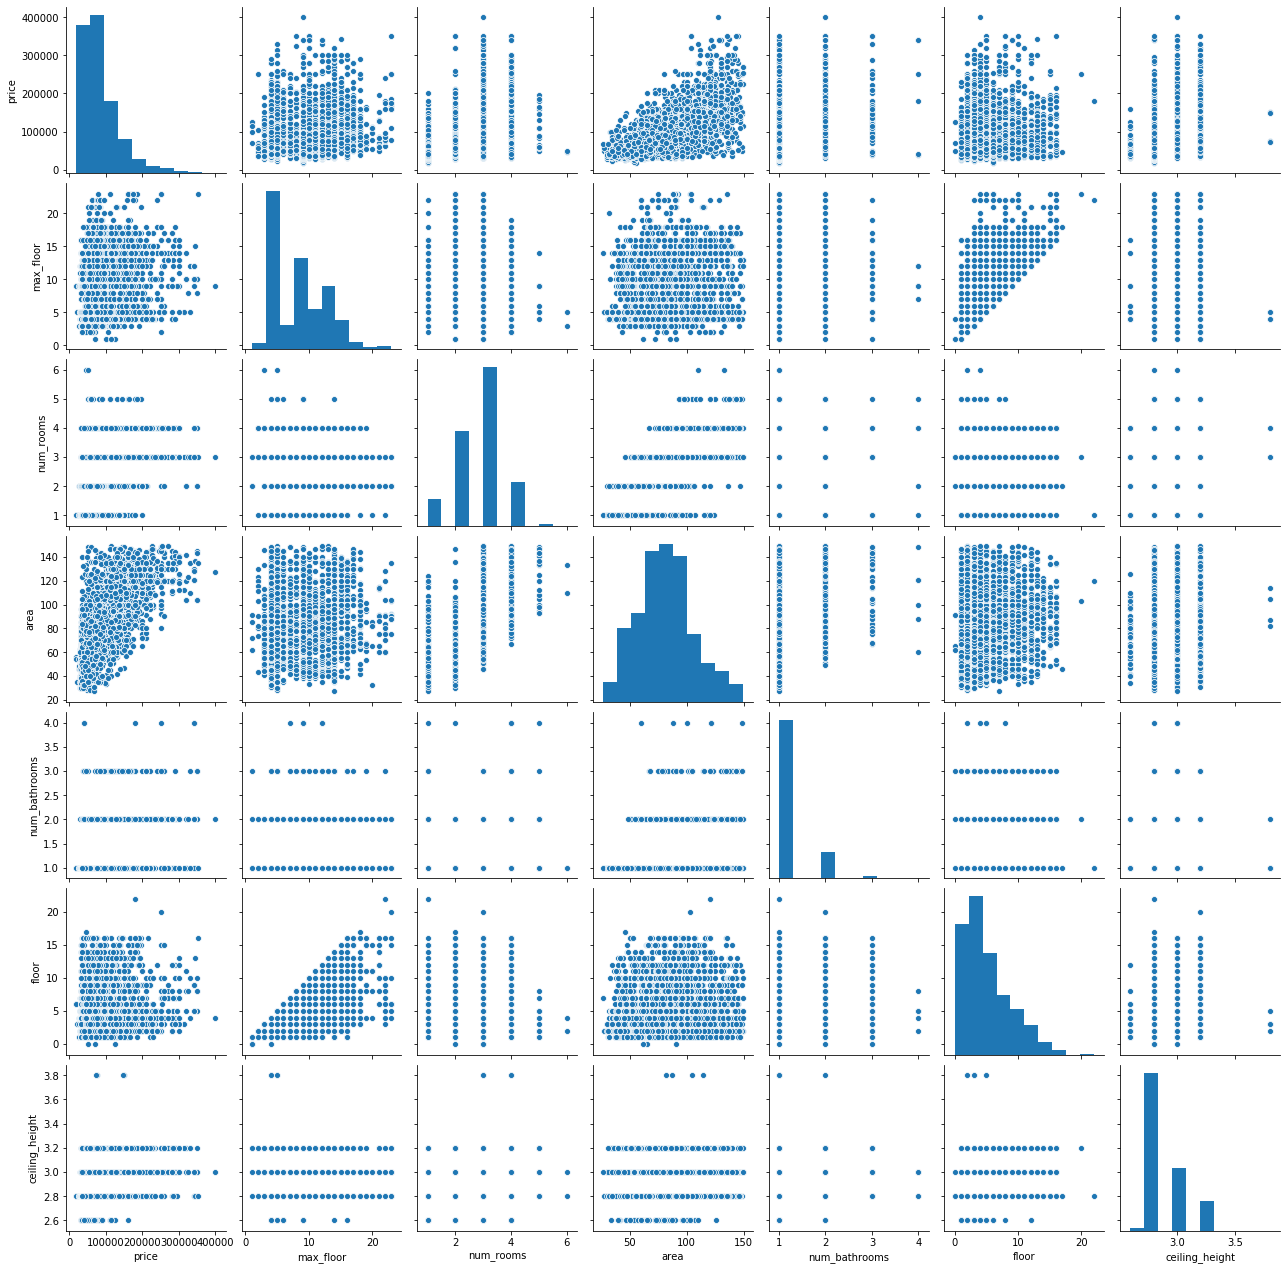

In [12]:
sns.pairplot(df_num)
plt.show()

In [13]:
df_num.columns

Index(['price', 'max_floor', 'num_rooms', 'area', 'num_bathrooms', 'floor',
       'ceiling_height'],
      dtype='object')

Only the 'area' feature has strong linear correlation with target ('price') feature.

In [14]:
df_num_corr = df_num.corr()['price'][1:]
strong_corr_columns = df_num_corr[abs(df_num_corr)>0.25].sort_values(ascending=False)
print("There is {} strongly correlated values with price:\n{}".format(len(strong_corr_columns), strong_corr_columns))

There is 4 strongly correlated values with price:
area              0.619113
num_bathrooms     0.429139
ceiling_height    0.380322
num_rooms         0.350601
Name: price, dtype: float64


It is quite objective that appartments which have big areas, more rooms and bathrooms and higher ceiling_height should be more expensive.
We can also check correlation of all features with each other.

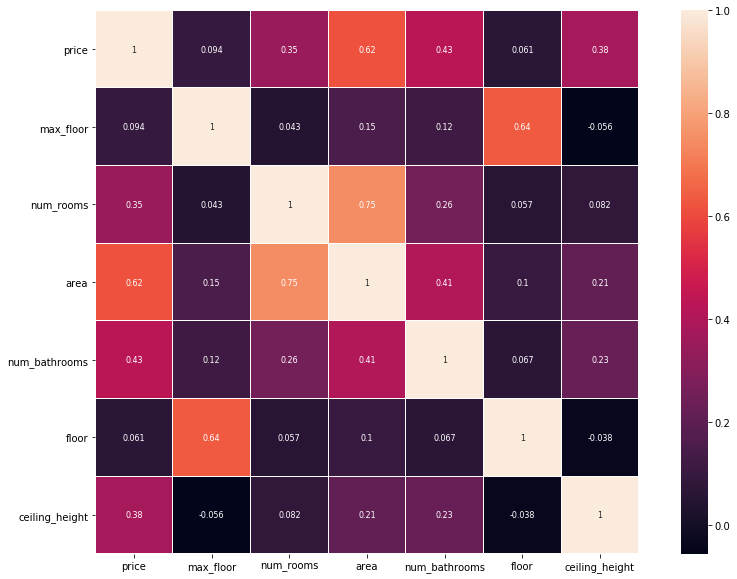

In [15]:
corrmat = df.corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(corrmat,square=True, linewidths=0.1, annot=True, annot_kws={"size": 8})

One possibly interesting information we can see from heatmap (besides correlations of area,num_rooms,num_bathrooms) is the negative correlation of ceiling_height with floor and max_floor, which could mean that the higher is the building the lower are the ceilings in the appartments.

Now let's explore our categorical features.

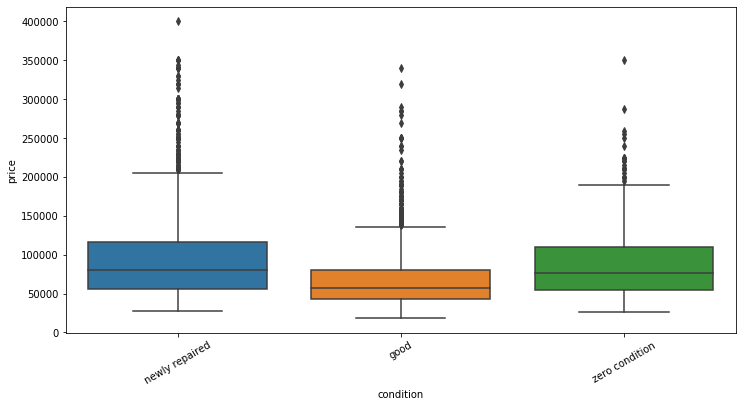

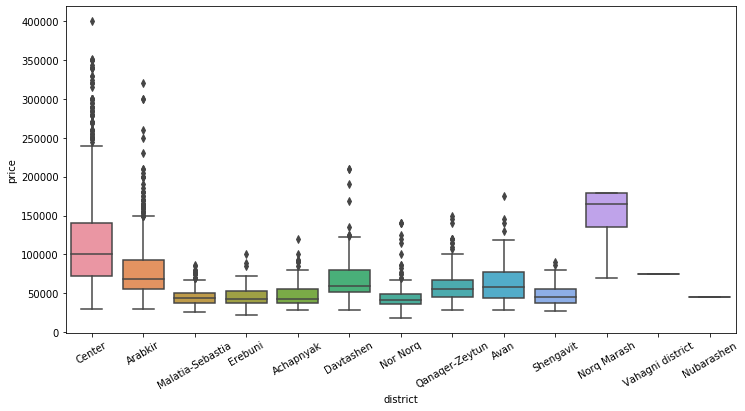

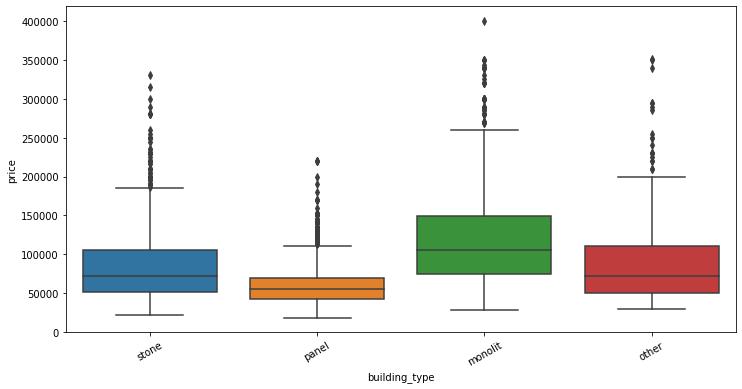

In [16]:
def plot_cat_relationship(df,df_obj,target):
    x = [i for i in df_obj.columns]
    for c in x:
        data = pd.concat([df[target],df_obj[c]],axis=1)
        fig,ax = plt.subplots(figsize=(12,6))
        ax = sns.boxplot(x=c,y=target,data=data)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plot_cat_relationship(df,df_obj,'price')

1. **Condition**:
It is normal that appartments which are in a very good condition will have higher prices, however it is strange that appartments with zero-condition have higher mean price that those with good condition.
2. **District**:
As we have already discovered appartments in Center and Arabkir. Davtashen and Norq Marash are also among the districts with high prices because they are growing and developing the living conditions quite fast.
3. **Buidling type**:
The most expensive appartments are in monolit buidlings, then stone and lastly (as expected) panel.

In order to be able to analyze categorical variables we should encode them.

In [8]:
data = pd.get_dummies(df,columns=['condition','district','building_type'])

In [20]:
print(df.shape)
print(data.shape)

(4999, 10)
(4999, 27)


Now we will separate target feature and features we will use to predict the target feature and split features on train and test parts.

In [14]:
X = data.drop(['price'],axis=1)
y = np.log(data['price'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=20)

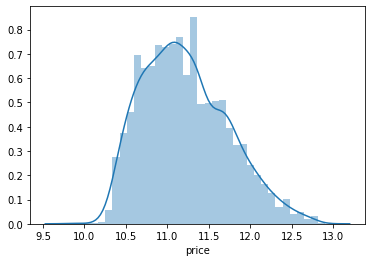

In [20]:
sns.distplot(y)

In [21]:
data.describe()

,price,max_floor,num_rooms,area,num_bathrooms,floor,ceiling_height,condition_good,condition_newly repaired,condition_zero condition,...,district_Nor Norq,district_Norq Marash,district_Nubarashen,district_Qanaqer-Zeytun,district_Shengavit,district_Vahagni district,building_type_monolit,building_type_other,building_type_panel,building_type_stone
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,...,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.0000,4999.000000,4999.000000,4999.000000,4999.000000
mean,85567.200040,8.697740,2.690738,81.521704,1.166033,5.166433,2.894739,0.342669,0.573315,0.084017,...,0.046609,0.001000,0.000200,0.040208,0.032607,0.0004,0.215043,0.090618,0.308662,0.385677
std,50912.053236,4.148752,0.822829,24.704437,0.408540,3.395897,0.144868,0.474649,0.494645,0.277441,...,0.210822,0.031613,0.014144,0.196466,0.177622,0.0200,0.410893,0.287094,0.461987,0.486804
min,18500.000000,1.000000,1.000000,27.000000,1.000000,0.000000,2.600000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,5.000000,2.000000,65.000000,1.000000,3.000000,2.800000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
50%,70000.000000,9.000000,3.000000,80.000000,1.000000,4.000000,2.800000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000
75%,105000.000000,11.000000,3.000000,97.000000,1.000000,7.000000,3.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,1.000000,1.000000
max,400000.000000,23.000000,6.000000,149.000000,4.000000,22.000000,3.800000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000


We see that some numerical features have a big spread between minimum and maximum values. Thus we will evaluate the performance of our model 3 times: without scaling, using MinMaxScaler and StandardScaler.

**Applying MinMaxScaler()**

In [22]:
norm = MinMaxScaler().fit(X_train)
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

**Applying StandardScaler()**
avoiding encoded categorical features

In [23]:
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = ['max_floor', 'num_rooms', 'area', 'num_bathrooms', 'floor','ceiling_height']

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

In [24]:
lr = LinearRegression()
rmse = []
r_squared = []

trainX = [X_train, X_train_norm, X_train_stand]
testX = [X_test, X_test_norm, X_test_stand]


for i in range(len(trainX)):
    lr.fit(trainX[i],y_train)
    pred = lr.predict(testX[i])
    rmse.append(np.sqrt(mean_squared_error(y_test,pred)))
    r_squared.append(metrics.r2_score(y_test,pred))
    


df_lr = pd.DataFrame({'RMSE':rmse, 'R^2':r_squared},index=['Original','Normalized','Standardized'])
df_lr

,RMSE,R^2
Original,2.456058e-01,7.858319e-01
Normalized,9.218369e+10,-3.017074e+22
Standardized,7.014086e+10,-1.746707e+22


As we can see the use of StandardScaler gives the best result

Now we will use **Ridge and Lasso** regression with X_test_stand, X_train_stand to see if our metrics will show better results.

**Ridge**

In [25]:
ridge = Ridge()
params = {'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_reg = GridSearchCV(ridge,params,scoring='neg_mean_squared_error',cv=7)
ridge_reg.fit(X_train_stand,y_train)
ridge_pred = ridge_reg.predict(X_test_stand)
print('Ridge with standardized data:')
print('Best alpha is:',ridge_reg.best_params_)
print('Best score is:',ridge_reg.best_score_)
print('RMSE for Ridge:',np.sqrt(mean_squared_error(y_test,ridge_pred)))

C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.60744e-20): result may not be accurate.
  overwrite_a=True).T


Ridge with standardized data:
Best alpha is: {'alpha': 0.01}
Best score is: -0.06172373898232854
RMSE for Ridge: 0.2456022037118946


In [29]:
ridge = Ridge()
params = {'alpha': [1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40,45,50,55,100]}
ridge_reg = GridSearchCV(ridge,params,scoring='neg_mean_squared_error',cv=7)
ridge_reg.fit(X_train,y_train)
ridge_pred = ridge_reg.predict(X_test)
print('Ridge on initial data:')
print('Best alpha is:',ridge_reg.best_params_)
print('Best score is:',ridge_reg.best_score_)
print('RMSE:',np.sqrt(mean_squared_error(y_test,ridge_pred)))

C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.48907e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.43436e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.42042e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.44647e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=4.4731e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_ri

Ridge on initial data:
Best alpha is: {'alpha': 0.01}
Best score is: -0.0617237321019234
RMSE: 0.24560209424660284


**Lasso**

In [27]:
lasso = Lasso()
lasso_reg = GridSearchCV(lasso,params,scoring='neg_mean_squared_error',cv=7)
lasso_reg.fit(X_train,y_train)
lasso_pred = lasso_reg.predict(X_test)
print('Lasso on initial data:')
print('Alpha:',lasso_reg.best_params_)
print('Best score:',lasso_reg.best_score_)
print('RMSE:',np.sqrt(mean_squared_error(y_test,lasso_pred)))

lasso_reg.fit(X_train_stand,y_train)
lasso_pred_stand = lasso_reg.predict(X_test_stand)
print('Lasso on standardized data:')
print('Alpha:',lasso_reg.best_params_)
print('Best score:',lasso_reg.best_score_)
print('RMSE:',np.sqrt(mean_squared_error(y_test,lasso_pred_stand)))

C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.97726657832577, tolerance: 0.0861296076817797
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.12438492321584, tolerance: 0.08898706466556755
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.54409730339371, tolerance: 0.0883475929003962
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Lasso on initial data:
Alpha: {'alpha': 1e-15}
Best score: -0.061723809261755705
RMSE: 0.24575235398555176


C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.1028534649156, tolerance: 0.0861296076817797
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.182546040967395, tolerance: 0.08898706466556755
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.76708421524624, tolerance: 0.0883475929003962
  positive)
C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

Lasso on standardized data:
Alpha: {'alpha': 1e-15}
Best score: -0.0617238092617557
RMSE: 0.24575235398555184


C:\Users\Admin\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.86213490296619, tolerance: 0.10342697895000477
  positive)


The model with Ridge regularization gives the best result.

Lastrly we will apply cross_validation to evaluate our model.

**Cross Validation**

Cross-val Training score: 0.7611333535586857
Cross-val Testing score: 0.7778506620538669
Cross-val predicted accuracy: 0.7616256198647877
Test-predictions accuracy: 0.7785464113994693
RMSE: 0.249748261157398


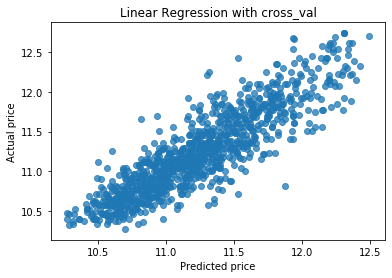

In [33]:
training_score = cross_val_score(lr,X_train,y_train,cv=5) 
testing_score = cross_val_score(lr,X_test,y_test,cv=5)
print("Cross-val Training score:", training_score.mean())
print("Cross-val Testing score:", testing_score.mean())

training_predictions = cross_val_predict(lr,X_train,y_train,cv=5)
testing_predictions = cross_val_predict(lr,X_test,y_test,cv=5)

training_accuracy = metrics.r2_score(y_train,training_predictions) 
test_accuracy = metrics.r2_score(y_test,testing_predictions)
    
print("Cross-val predicted accuracy:", training_accuracy)
print("Test-predictions accuracy:",test_accuracy)
print('RMSE:',np.sqrt(mean_squared_error(y_test,testing_predictions)))

plt.scatter(testing_predictions,y_test, alpha=.75)
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Linear Regression with cross_val')
plt.show()

Conclusion: The best result was obtained by using Ridge Regression model.

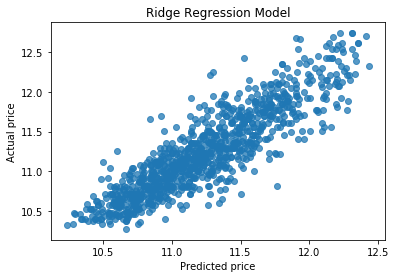

In [31]:
plt.scatter(ridge_pred, y_test, alpha=.75)
plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Ridge Regression Model')
plt.show()

Moreover, we should also convert ridge_pred prices back to normal scale by applying np.exp(ridge_pred)

In [34]:
final_price_predictions = np.exp(ridge_pred)